# Финальный проект, 1 вариант

### Задание 1
#### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
#### Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [20]:
reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-li-kim/shared/problem1-reg_data.csv'

In [21]:
auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-li-kim/shared/problem1-auth_data.csv'

In [22]:
reg_data = pd.read_csv(reg, sep=';')

In [23]:
auth_data = pd.read_csv(auth, sep=';')

In [24]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [25]:
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


#### В первую очередь проводим предварительный анализ данных.

Проверяю что нет задвоенных значений uid в датафрейме reg_date.

In [26]:
reg_data.uid.nunique()

1000000

Посмотрим тип данных в обоих датафреймах.

In [27]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [28]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

Посмотрим есть ли незаполненные поля.

In [29]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [30]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Ошибок в обоих датафремах обнаруженно не было. Переведем даты из int в date чтобы посмотреть на диапозон дат.

In [31]:
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date

In [32]:
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date

In [33]:
reg_data

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [34]:
auth_data

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [35]:
reg_data.reg_ts.min() 

datetime.date(1998, 11, 18)

In [36]:
reg_data.reg_ts.max()

datetime.date(2020, 9, 23)

Видим что датафремы содержат данные за 22 года.

Напишем функцию для подсчета retention.

In [37]:
def retention(reg, auth, first_date, last_date):
    
    # читаем датафреймы
    reg_data = pd.read_csv(reg, sep=';')
    auth_data = pd.read_csv(auth, sep=';')
    
    # Объединим датафреймы по uid
    full_df = auth_data.merge(reg_data, how='left', on='uid')
    
    # устанавливаем первую и последнюю даты в формате datetime
    first_date = datetime.strptime(first_date, '%Y-%m-%d').date()
    last_date = datetime.strptime(last_date, '%Y-%m-%d').date()
    
    # переводим даты из датафрейма из int в datetime
    full_df['reg_ts'] = pd.to_datetime(full_df.reg_ts, unit='s').dt.date
    full_df['auth_ts'] = pd.to_datetime(full_df.auth_ts, unit='s').dt.date
    
    # ограничим датафрейм рамками первой и последней даты запроса
    full_df = full_df.query('reg_ts   >= @first_date and reg_ts  <= @last_date')
    full_df = full_df.query('auth_ts >= @first_date and auth_ts <= @last_date')
    
    # добавляем колонку с разницей в днях между временем захода и регистрацией, таким образом узнаем сколько дней 
    # прошло с момента регистрации
    full_df['day_period'] = (full_df.auth_ts - full_df.reg_ts).dt.days
    
    # группируем датафрем по дате регистрации и количеству дней с момента регистрации и формируем "косынку"
    full_df = full_df.groupby(['reg_ts', 'day_period']).agg({'uid': 'nunique'})
    full_df = full_df.reset_index().pivot(index='reg_ts', columns='day_period', values='uid')
    full_df = full_df.div(full_df[0], axis=0).mul(100).round(2)
    
    # визуализируем результат
    sns.set(style='ticks', rc={"figure.figsize": (15, 8)})
    plt.title('Cohorts: Users retention by days from the date of registration')
    sns.heatmap(data=full_df.div(100, axis=0), annot=True, fmt='.0%', vmin=0.0, vmax=0.15, cmap='Blues')
    
    return full_df

Проверяем получившуюся функцию.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


day_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_ts,,,,,,,,,,,,,,,,
2015-05-05,100.0,3.08,6.15,7.69,7.69,12.31,4.62,6.15,6.15,3.08,4.62,3.08,6.15,7.69,4.62,4.62
2015-05-06,100.0,4.62,NaN,4.62,3.08,6.15,15.38,6.15,4.62,4.62,3.08,6.15,3.08,10.77,4.62,NaN
2015-05-07,100.0,3.08,4.62,10.77,6.15,10.77,9.23,4.62,6.15,7.69,9.23,7.69,9.23,4.62,NaN,NaN
2015-05-08,100.0,1.54,1.54,4.62,3.08,7.69,4.62,7.69,4.62,4.62,NaN,9.23,3.08,NaN,NaN,NaN
2015-05-09,100.0,NaN,NaN,4.62,1.54,10.77,7.69,3.08,3.08,3.08,7.69,4.62,NaN,NaN,NaN,NaN
2015-05-10,100.0,1.54,4.62,4.62,9.23,3.08,10.77,4.62,6.15,1.54,9.23,NaN,NaN,NaN,NaN,NaN
2015-05-11,100.0,4.62,6.15,6.15,7.69,3.08,10.77,4.62,3.08,9.23,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,100.0,1.54,10.77,4.62,1.54,7.69,1.54,10.77,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-13,100.0,NaN,1.52,6.06,1.52,3.03,10.61,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


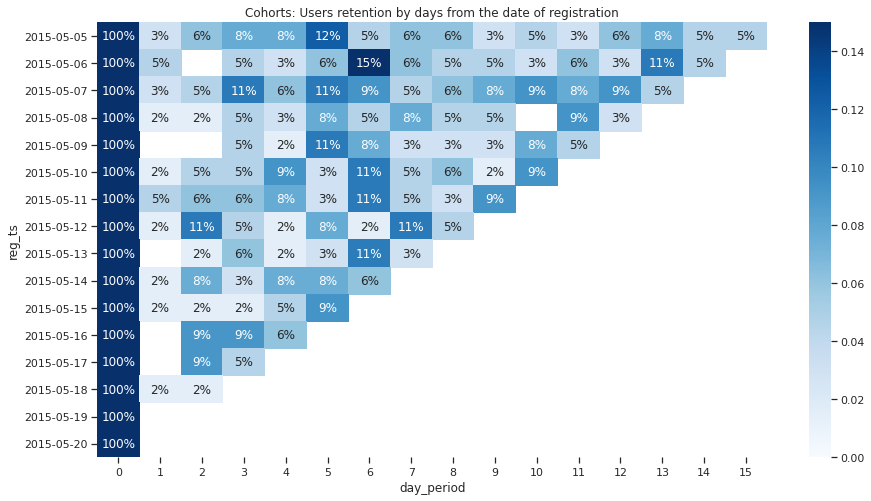

In [38]:
retention(reg, auth, '2015-05-05', '2015-05-20')

### Задание 2

#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
#### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-li-kim/Final_project/Проект_1_Задание_2.csv'

In [4]:
task2 = pd.read_csv(path_to_file, sep=';')

In [5]:
task2

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Разделяем данные по группам

In [6]:
group_a = task2.query("testgroup == 'a'")

In [7]:
group_a

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [8]:
group_b = task2.query("testgroup == 'b'")

In [9]:
group_b

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


In [10]:
group_a.user_id.nunique()

202103

In [11]:
group_b.user_id.nunique()

202667

Видим что в обоих группах количество уникальных пользователей совпадает с общим количеством пользователей, т.е. каждый user_id представлен в группе только один раз.

In [12]:
task2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Видим, что пропущенных значений в датафрейме нет.

Метрики для анализа: ARPU, ARPPU, доля платящих игроков.

Сначала проанализируем ARPU. В условии сказано что этот показатель в группе "b" больше на 5%, проверим это и узнаем являются ли эти различия стат значимыми.

Посчитаем ARPU в обоих группах

In [13]:
group_a.revenue.mean()

25.413719736965806

In [14]:
group_b.revenue.mean()

26.75128659327863

Как и указано в условии ARPU в группе "b" действительно выше на 5%

Проверяю на нормальность распределения revenue в группах визуально и через тест Шапиро

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


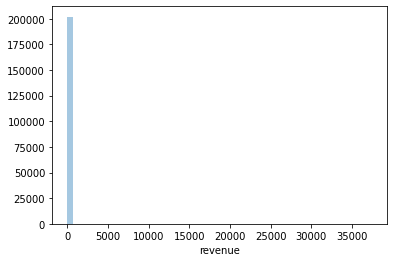

In [15]:
sns.distplot(group_a.revenue, kde=False)

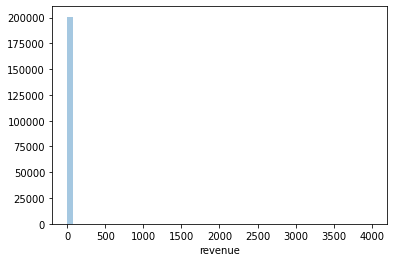

In [16]:
sns.distplot(group_b.revenue, kde=False)

In [17]:
ss.shapiro(group_a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [18]:
ss.shapiro(group_b.revenue)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

Распределения не являются нормальными. 
В данных есть нули, т.к. не все пользователи платящие. Избавиться от неплатящих пользователей для  метрики ARPU мы тоже не можем, так как эта метрика показывает средний доход на всех пользователей. Поэтому будем логорифмировать с помощью np.log1p, таким образом приобразовав функцию в log(1 + x).

In [19]:
group_a['revenue_log'] = np.log1p(group_a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
group_b['revenue_log'] = np.log1p(group_b.revenue)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


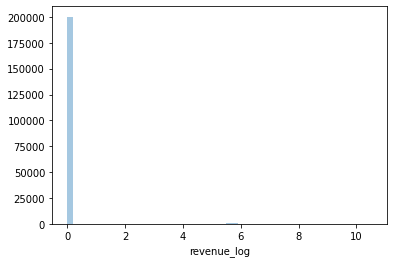

In [21]:
sns.distplot(group_a.revenue_log, kde=False)

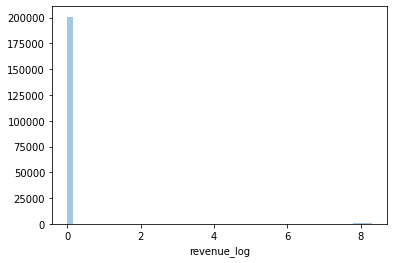

In [22]:
sns.distplot(group_b.revenue_log, kde=False)

Логарифмирование ни как не повлияло на нормальность распределений. Чтобы применить t-test, нужно проверить являются ли дисперсии внутри наших групп гомогенными. Воспользуемся критерием Левина.

H0 - обе группы имеют одинаковую диспресию.

H1 - дисперсии в группах различается.

In [23]:
ss.levene(group_a.revenue, group_b.revenue, center='median')

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Мы видим что p-значение составляет не менее 0,05. Это означает, что  мы не можем отвергнуть нулевую гипотезу. 

Так как обе группы имеют одинаковую дисперсию и размер выборок достаточно большой, мы можем применить t-test чтобы проверить являются ли различия в ARPU стат значимыми.

H0: никакого различия между средними revenue при ARPU в обоих группах нет.

H1: cуществует значительное различие между средними revenue при ARPU в обоих группах нет.

In [24]:
ss.ttest_ind(group_a.revenue_log, group_a.revenue_log)

Ttest_indResult(statistic=0.0, pvalue=1.0)

По результатам теста мы не можем опровергнуть нулевую гипотезн, а значит увеличение ARPU на 5% в группе "b" не является статистически значимым.

Теперь проверим ARPPU. Для этого возьмем данные только с платящими пользователями.

In [25]:
revenue_more0_a = group_a.query("revenue > 0")

In [26]:
revenue_more0_b = group_b.query("revenue > 0")

Сначала посмотрим на распределения revenue в этих группах.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


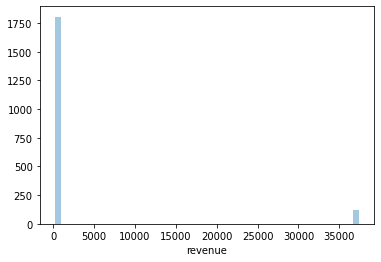

In [27]:
sns.distplot(revenue_more0_a.revenue, kde=False)

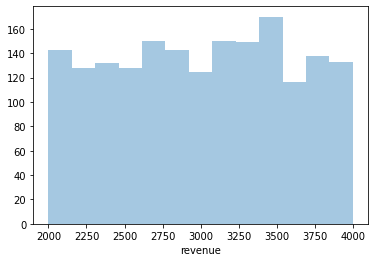

In [28]:
sns.distplot(revenue_more0_b.revenue, kde=False)

На графиках видно что в группе "a" revenue в основоном сравнительно небольшой, но есть большие выбросы, в то время как распределение revenue в группе "b" более  менее равномерно и revenue на пользователя выше. Оба распределения не являются нормальными, попробуем их логорифмировать и посмотреть результат. 

In [29]:
revenue_more0_a['revenue_log'] = np.log(revenue_more0_a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
revenue_more0_b['revenue_log'] = np.log(revenue_more0_b.revenue)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


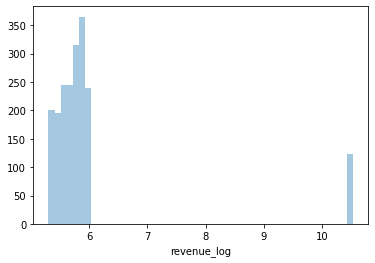

In [31]:
sns.distplot(revenue_more0_a.revenue_log, kde=False)

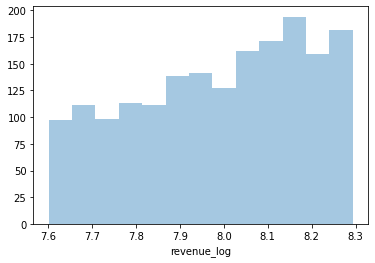

In [32]:
sns.distplot(revenue_more0_b.revenue_log, kde=False)

Логорифмирование не помогло сделать распределения нормальными. 

Теперь посчитает ARPPU в этих группах.

In [33]:
revenue_more0_a.revenue.mean()

2663.9984439834025

In [34]:
revenue_more0_b.revenue.mean()

3003.6581717451522

ARPPU в группе "b" выше на 11%, посмотрим есть ли стат значимость в этих различиях.

Интересно посмотреть так же на ARPPU в группе "a", если убрать выбросы.

In [35]:
revenue_less35000_a = revenue_more0_a.query("revenue < 35000")

In [36]:
revenue_less35000_a.revenue.mean()

302.45817174515236

ARPPU в группе "a" без выбросов значительно ниже, возьмем это на заметку.

Хотя на графиках и так видно что дисперсии в группах не являются гомогенными, но все же проверим это с помощью критерия Левена.

In [37]:
ss.levene(revenue_more0_a.revenue, revenue_more0_b.revenue, center='median')

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Так как исходя из теста Левена дисперсии в группах не гомогенные, применим Т-тест Уэлча, он применяется когда дисперсии двух наборов данных не одинаковы.

H0: никакого различия между средними revenue при ARPPU в обоих группах нет.

H1: cуществует значительное различие между средними revenue при ARPPU в обоих группах нет.

In [44]:
ss.ttest_ind(revenue_more0_a.revenue, revenue_more0_b.revenue, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

Исходя из результатов теста никакого различия между средними revenue при ARPPU в обоих группах нет.

Теперь посмотрим на долю платящих пользователей в обоих группах.

Платящие пользователи в группе "a"

In [75]:
revenue_more0_a.user_id.count()

1928

Не платящие пользователи в группе "a"

In [76]:
group_a.user_id.count() - revenue_more0_a.user_id.count()

200175

Доля платящих пользователей в группе "a"

In [77]:
revenue_more0_a.user_id.count() / group_a.user_id.count()

0.009539690157988749

Платящие пользователи в группе "b"

In [78]:
revenue_more0_b.user_id.count() 

1805

Не платящие пользователи в группе "b"

In [79]:
group_b.user_id.count() - revenue_more0_b.user_id.count()

200862

Доля платящих пользователей в группе "b"

In [80]:
revenue_more0_b.user_id.count() / group_b.user_id.count()

0.008906235351586593

Визуально различия в доле платящих пользователей в обоих группах очень малы, но все же в группе "a" она выше на 6%. На всякий случай проверим, являются ли эти небольшие различия стат значимыми. Создадим таблицу сопряженности и применим критерий хи квадрат. 

H0: распределение платящих пользователей не зависит от группы.

H1: распределение платящих пользователей зависит от группы, а значит и от акционных предложений в этих группах.

In [81]:
table = [[200175, 1928], [200862, 1805]]

chi2, prob, df, expected = ss.chi2_contingency(table)
chi2, prob, df

(4.374729521260405, 0.03647561892312613, 1)

Мы выяснили что доля платящих пользователей в группе "a" выше не случайно, и скорее всего связанна с акционным предложеним в этой группе.

#### Подведем итог
После проведения статистических тестов, мы  выяснили, что ARPU и ARPPU выше в группе "b", но эти данные оказались статистически не значимы. В то время как доля платящих пользователей статистически значимо выше в группе "a".

#### Вывод

Полученые данные слабо говорят о том что какой-то из наборов предложений является лучшим. Различия в таких важных метриках как ARPU и ARPPU оказались статистически не значимыми. Едва ли можно говорить об эффективности групп исходя только из доли платящих пользователей. К тому же, revenue в группах выглядят странно. Слишком разные, непересекающиеся сегменты пользователей по величине оплат. Думаю, что в данном случае возможно нарушена система сплитования. Скорее всего, требуется перепроверить как происходит сплитование между группами, и в случае нахождения ошибки, пересобрать группы и повторить эксперимент.

### Задание 3

#### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?
В каждом отделе есть свои метрики оценивающие результаты тематического события. В левел дизайне они одни, у художников другие и т.д. Но если мы рассматриваем глобальные цели компании при проведении тематических событий, то это получение дохода и возобновление интереса к игре. Поэтому основные метрики, которые оценивают результат прошедшего события это:

Retenion - чтобы оценить насколько заинтересовало игроков данное событие, насколько часто они возвращались в игру.

ARPU и ARPPU - оценить доходность события в разрезе всех пользователей и только платящих игроков.

Так же можно дополнительно использовать следующие метрики, для детального изучения успешности события:

Время в игре в сутки и за сессию - чтобы понимать на сколько игрока "затягивает" данное событие.

Churn rate - для того чтобы отслеживать как то или иное событие влияет на отток игроков.

Количество пройденных уровней в сутки и за сессию - помимо того, что можно видеть на сколько интересно игроку в игре, так можно отследить на сколько легко проходятся уровни.

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?
Для данного изменения в механике события, в дополнение в вышеперечисленным метрикам можно добавить следующие:
Количество попыток прохождения уровней, количество откатов по уровням - чтобы понимать насколько интересна игроку данная механика, станет ли он снова и снова проходить сет одних и тех же уровней чтобы подобраться к сложному.